In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
image_size=128

In [4]:

image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images'
groundtruth_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth'

In [5]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)

['.ipynb_checkpoints', '01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png', '03_1.png', '03_2.png', '03_3.png', '03_4.png', '03_5.png', '04_1.png', '04_2.png', '04_3.png', '04_4.png', '04_5.png', '04_6.png', '04_7.png', '04_8.png', '05_1.png', '05_2.png', '05_3.png', '05_4.png', '06_1.png', '06_2.png', '06_3.png', '07_1.png', '07_2.png', '07_3.png', '08_1.png', '08_2.png', '08_3.png', '08_4.png', '09_1.png', '09_2.png', '09_3.png', '09_4.png', '09_5.png', '09_6.png', '10_1.png', '10_2.png', '10_3.png', '10_4.png', '11_1.png', '11_2.png', '11_3.png']


In [6]:
for img in img_id:
  path=image_path+img
  print(path)

/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images.ipynb_checkpoints
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_1.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_2.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_3.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_4.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_5.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_6.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images01_7.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images02_1.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images02_2.png
/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmen

In [7]:
mask_id=[]
for mask in os.listdir(groundtruth_path):
  mask_id.append(mask)
  #print(img_id)
mask_id.sort()
print(mask_id)

['01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png', '03_1.png', '03_2.png', '03_3.png', '03_4.png', '03_5.png', '04_1.png', '04_2.png', '04_3.png', '04_4.png', '04_5.png', '04_6.png', '04_7.png', '04_8.png', '05_1.png', '05_2.png', '05_3.png', '05_4.png', '06_1.png', '06_2.png', '06_3.png', '07_1.png', '07_2.png', '07_3.png', '08_1.png', '08_2.png', '08_3.png', '08_4.png', '09_1.png', '09_2.png', '09_3.png', '09_4.png', '09_5.png', '09_6.png', '10_1.png', '10_2.png', '10_3.png', '10_4.png', '11_1.png', '11_2.png', '11_3.png']


In [8]:
from PIL import Image

In [9]:
used_ids=[]

In [10]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, batch_size=8, image_size=128):
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path ='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images'+'/'+id_name
        mask_path = '/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth'+'/'+id_name
       
        
        ## Reading Image
        
        image = cv2.imread(image_path, 1)
        
          
        mask = cv2.imread(mask_path, 0)
        if(image is None or mask is None):
          print("Error: ",id_name)
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        
        
          
          
        ## Normalizaing 
        mask[mask>0]=255
        #print(np.unique(mask))
        image = image/255.0
        mask = mask/255.0

        #print(np.unique(mask))
        return image, mask
    
    def __getitem__(self, index):
        # if(index+1)*self.batch_size > len(self.ids):
        #     self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        print(len(files_batch))
        if(len(files_batch)<self.batch_size):
          files_batch.extend(self.ids[0:self.batch_size-len(files_batch)])
        image = []
        mask  = []
        
        for i,id_name in enumerate(files_batch):
            while(not id_name.split('.')[1]=='png'):
              id_name=files_batch[i+1]
              i+=1
              if(i>=self.batch_size):
                i=0
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
              
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [11]:
image_size = 128
epochs = 50
batch_size = 8

## Training Ids
train_ids = img_id

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [12]:

gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
for x,y in gen:
  print(x.shape)

8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
8
(8, 128, 128, 3)
1
(8, 128, 128, 3)


In [13]:
gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
# y_copy=y.copy()
print(x.shape, y.shape)

8
(8, 128, 128, 3) (8, 128, 128)


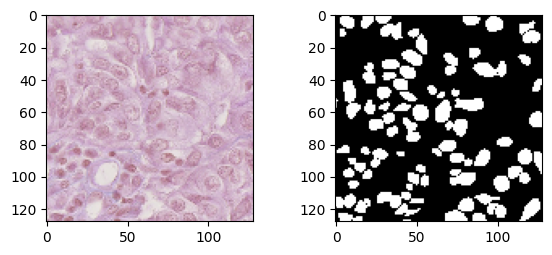

In [14]:
# r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap="gray")

In [15]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [16]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

#50 epoch result

In [18]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(used_ids)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)
print(len(np.unique(used_ids)))
print(used_ids)

[]
8


<ipython-input-18-758a56b68243>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.5469 - acc: 0.84978
8
2
5/5 [==============================] - 18s 3s/step - loss: 0.5469 - acc: 0.8497 - val_loss: 0.3524 - val_acc: 0.8956
Epoch 2/50
1
8
5/5 [==============================] - ETA: 0s - loss: 0.4729 - acc: 0.85768
2
5/5 [==============================] - 8s 2s/step - loss: 0.4729 - acc: 0.8576 - val_loss: 0.4336 - val_acc: 0.8957
Epoch 3/50
1
8
5/5 [==============================] - ETA: 0s - loss: 0.4421 - acc: 0.84918
2
5/5 [==============================] - 9s 2s/step - loss: 0.4421 - acc: 0.8491 - val_loss: 0.3251 - val_acc: 0.8957
Epoch 4/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.4002 - acc: 0.85718
2
5/5 [==============================] - 9s 2s/step - loss: 0.4002 - acc: 0.8571 - val_loss: 0.3237 - val_acc: 0.8957
Epoch 5/50
1
8
5/5 [==============================] - ETA: 0s - loss: 0.3982 - acc: 0.85148
2
5/5 [==============================] - 7s 1s/step - loss: 0.398

In [19]:
print(used_ids)

[]


In [20]:
## Save the Weights
#model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.3

2
1/1 [==============================] - 0s 452ms/step


In [21]:
print(np.unique(result))

[False  True]


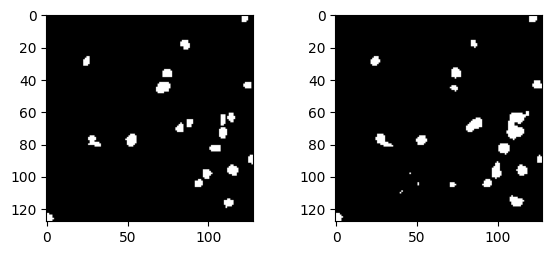

In [22]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

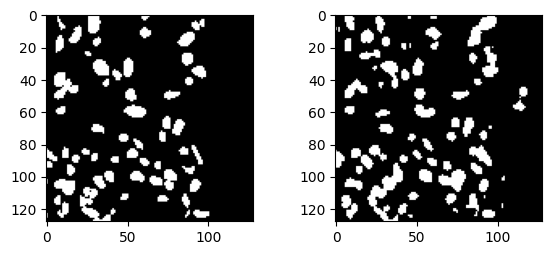

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size,1)), cmap="gray")

In [24]:
model.save_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_50.h5')

In [25]:
model.load_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_50.h5')

#100 epoch results


In [26]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
print(used_ids)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)
print(len(np.unique(used_ids)))
print(used_ids)

[]
8


<ipython-input-26-758a56b68243>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.1915 - acc: 0.91768
8
2
5/5 [==============================] - 8s 2s/step - loss: 0.1915 - acc: 0.9176 - val_loss: 0.1056 - val_acc: 0.9557
Epoch 2/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.1866 - acc: 0.91888
2
5/5 [==============================] - 11s 2s/step - loss: 0.1866 - acc: 0.9188 - val_loss: 0.1007 - val_acc: 0.9571
Epoch 3/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.91998
2
5/5 [==============================] - 10s 2s/step - loss: 0.1901 - acc: 0.9199 - val_loss: 0.1113 - val_acc: 0.9522
Epoch 4/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.1929 - acc: 0.91698
2
5/5 [==============================] - 7s 1s/step - loss: 0.1929 - acc: 0.9169 - val_loss: 0.1009 - val_acc: 0.9582
Epoch 5/50
8
8
5/5 [==============================] - ETA: 0s - loss: 0.1873 - acc: 0.91988
2
5/5 [==============================] - 10s 2s/step - loss: 0.1

In [27]:
## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.3

2
1/1 [==============================] - 0s 272ms/step


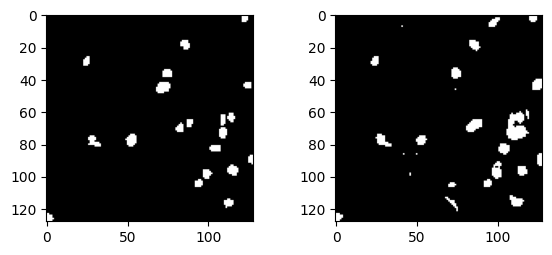

In [28]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

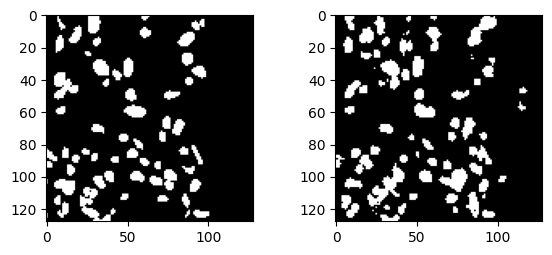

In [29]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size,1)), cmap="gray")

In [30]:
model.save_weights('/content/drive/MyDrive/Hepatoma-Staging-Project/Weights/UnetW_100.h5')